In [58]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

#for evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

# Load Data

In [59]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.220000,5.070000,5.200000,5.120000,6105900.0,4.826837
2012-01-04,5.180000,4.970000,5.090000,5.030000,5268700.0,4.741990
2012-01-05,5.480000,5.070000,5.150000,5.470000,8216100.0,5.156795
2012-01-06,5.670000,5.400000,5.440000,5.600000,8323000.0,5.279352
2012-01-09,5.800000,5.550000,5.560000,5.720000,8029900.0,5.392481
...,...,...,...,...,...,...
2021-08-31,20.020000,19.360001,19.469999,19.940001,24993200.0,19.940001
2021-09-01,20.100000,19.530001,20.010000,19.639999,20843200.0,19.639999
2021-09-02,19.980000,19.480000,19.730000,19.760000,20179400.0,19.760000


# Modeling

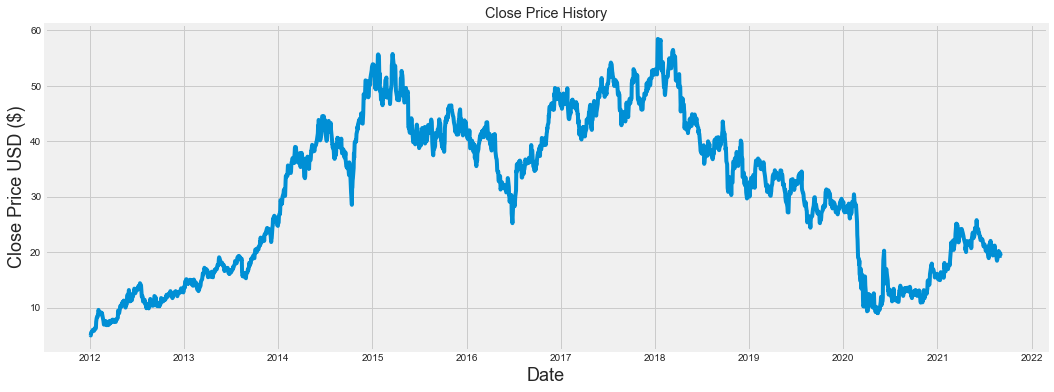

In [60]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [61]:
# Create a new dataframe with only the 'Close column
#data= AAPL['Close'].values.reshape(-1, 1)
data = df.filter(['Close'])
data

,Close
Date,
2012-01-03,5.120000
2012-01-04,5.030000
2012-01-05,5.470000
2012-01-06,5.600000
2012-01-09,5.720000
...,...
2021-08-31,19.940001
2021-09-01,19.639999
2021-09-02,19.760000


In [62]:
# Convert the dataframe to a numpy array
dataset = data.values

In [63]:
dataset.shape

(2436, 1)

In [64]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [65]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [66]:
train_data.shape

(2193, 1)

In [67]:
def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [68]:
train_1, val_1 = train_val(train_data)

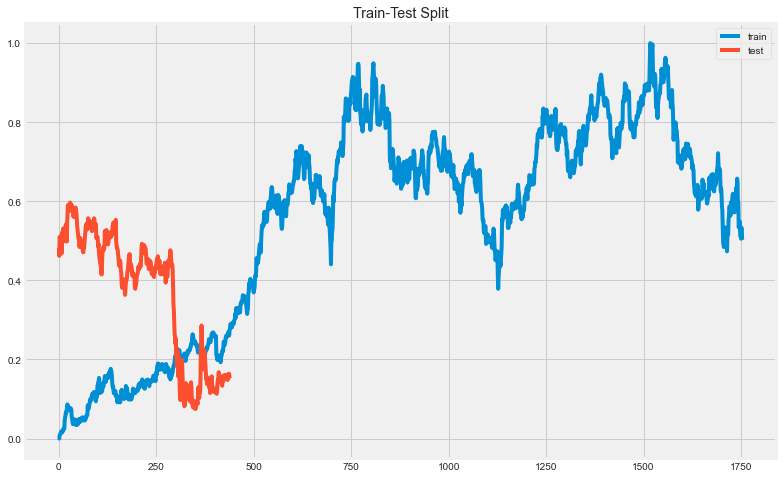

In [69]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_1, label='train')
ax.plot(val_1, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [70]:
#The LSTM needs data with the format of [samples, time steps and features]
#[10 20 30] 40
#[20 30 40] 50
#[30 40 50] 60
#using the size of time step as a batch to predict the next value 

def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [71]:
def prepare_training(data, n_steps):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequence(train, n_steps)
    x_val, y_val = split_sequence(val, n_steps)
    features = 1
    return x_train, y_train, x_val, y_val, features


In [72]:
# Model
def creat_model1(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [73]:
def creat_model2(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


In [74]:
#Bidirectional allows the model learn the input sequence both forward and backwards

def creat_model3(n_steps, features):
    model = Sequential()
    model.add(LSTM(200, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=False)))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [75]:
def creat_model4(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_steps, features), return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [76]:
n_steps = 10

x_train, y_train, x_val, y_val, feature = prepare_training(train_data,n_steps)

In [77]:
x_train.shape

(1744, 10, 1)

In [78]:
y_train.shape

(1744, 1)

In [79]:
#Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

## Test data set

In [80]:
test_data = scaled_data[training_data_len: , :]
x_test, y_test = split_sequence(test_data, n_steps)

In [81]:
y_test_re = scaler.inverse_transform(y_test)

In [82]:
y_test_re.shape

(233, 1)

## Model 1

In [83]:
model1 = creat_model1(n_steps, feature)

In [84]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 2s 26ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 7.6013e-04 - val_mean_squared_error: 7.6013e-04
Epoch 3/50
35/35 [==============================] - 1s 19ms/step - loss: 6.7546e-04 - mean_squared_error: 6.7546e-04 - val_loss: 8.2177e-04 - val_mean_squared_error: 8.2177e-04
Epoch 4/50
35/35 [==============================] - 1s 20ms/step - loss: 6.4116e-04 - mean_squared_error: 6.4116e-04 - val_loss: 7.2741e-04 - val_mean_squared_error: 7.2741e-04
Epoch 5/50
35/35 [==============================] - 1s 20ms/step - loss: 5.9958e-04 - mean_squared_error: 5.9958e-04 - val_loss: 7.1328e-04 - val_mean_squared_error: 7.1328e-04
Epoch 6/50
35/35 [==============================] - 1s 20ms/step - loss: 6.0118e-04 - mean_squared_error: 6.0118e-04 - val_loss: 7.2498e-04

In [85]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               66560     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Get the models predicted price values 
predictions1 = model1.predict(x_test)

In [87]:
predictions1.shape

(233, 1)

In [88]:
predictions1 = scaler.inverse_transform(predictions1)

In [89]:
# Get the root mean squared error (RMSE)
##import math
#math.sqrt(mean_squared_error(y_test_re,predictions))
rmse1 = np.sqrt(np.mean(((predictions1 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：0.9149


## Model 2

In [90]:
model2 = creat_model2(n_steps, feature)

In [91]:
history2 = model2.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 3s 26ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/50
35/35 [==============================] - 1s 15ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/50
35/35 [==============================] - 0s 14ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/50
35/35 [==============================] - 0s 14ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/50
35/35 [==============================] - 1s 15ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/50
35/35 [==============================] - 0s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
35/35 [================

In [92]:
predictions2 = model2.predict(x_test)

In [93]:
predictions2 = scaler.inverse_transform(predictions2)

In [94]:
rmse2 = np.sqrt(np.mean(((predictions2 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')

RMSE：1.0519


## Model 3

In [95]:
model3 = creat_model3(n_steps, feature)

In [ ]:
history3 = model3.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 4s 54ms/step - loss: 0.1045 - mean_squared_error: 0.1045 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 6.8924e-04 - val_mean_squared_error: 6.8924e-04
Epoch 3/50
35/35 [==============================] - 2s 43ms/step - loss: 6.9443e-04 - mean_squared_error: 6.9443e-04 - val_loss: 6.8220e-04 - val_mean_squared_error: 6.8220e-04
Epoch 4/50
35/35 [==============================] - 2s 44ms/step - loss: 6.0796e-04 - mean_squared_error: 6.0796e-04 - val_loss: 8.7999e-04 - val_mean_squared_error: 8.7999e-04
Epoch 5/50
35/35 [==============================] - 2s 44ms/step - loss: 6.5046e-04 - mean_squared_error: 6.5046e-04 - val_loss: 7.0169e-04 - val_mean_squared_error: 7.0169e-04
Epoch 6/50
35/35 [==============================] - 2s 46ms/step - loss: 5.3483e-04 - mean_squared_error: 5.3483e-04 - val_loss: 6.7363e-04

In [ ]:
predictions3 = model3.predict(x_test)

In [ ]:
predictions3.shape

In [ ]:
predictions3 = scaler.inverse_transform(predictions3)

In [ ]:
rmse3 = np.sqrt(np.mean(((predictions3 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse3, 4)}')

## Model 4

In [ ]:
model4 = creat_model4(n_steps, feature)

In [ ]:
history4 = model4.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

In [ ]:
predictions4 = model4.predict(x_test)

In [ ]:
predictions4 = scaler.inverse_transform(predictions4)

In [ ]:
rmse4 = np.sqrt(np.mean(((predictions4 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse4, 4)}')

## Plots

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

In [ ]:
plt.plot(history3.history['mean_squared_error'])
plt.plot(history3.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y_test_re)
plt.plot(predictions3)
plt.legend(['Real Value','Predicted Value']);

In [ ]:
train = data[:training_data_len]
test = data[training_data_len+10:]

In [ ]:
test.shape

In [ ]:
predictions3.shape

In [ ]:
test['Predictions'] = predictions3

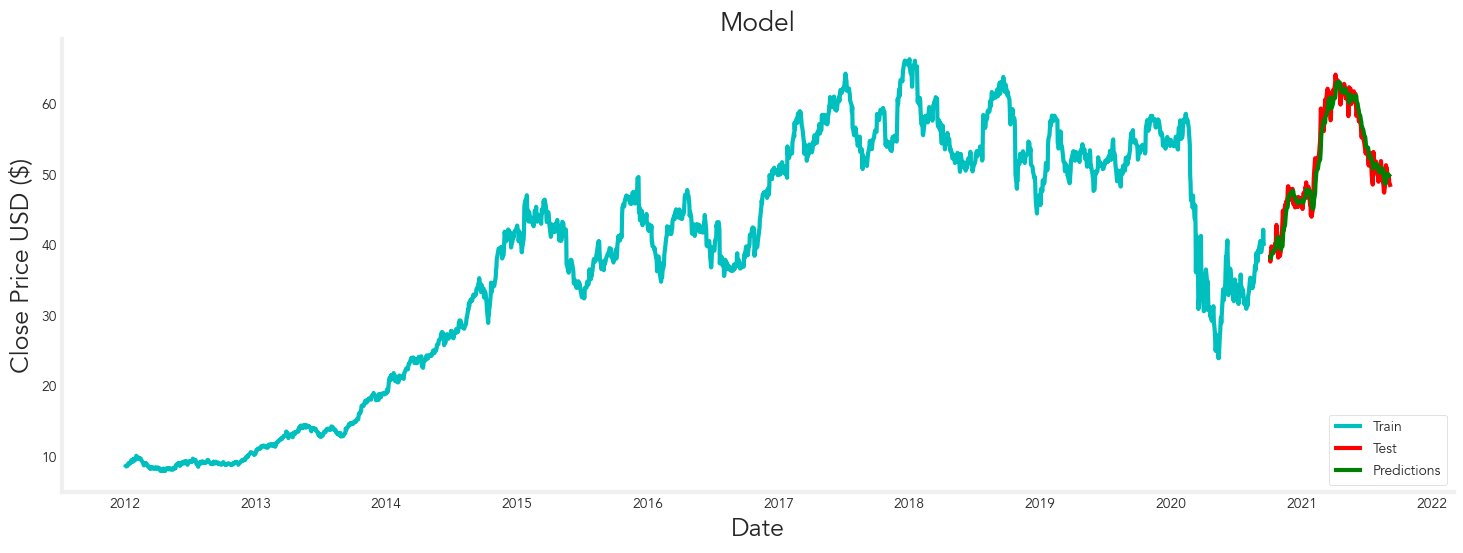

In [56]:
# Visualize the data

with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(16,6))
    plt.title('LSTM Model for American Airlines')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], 'c')
    plt.plot(test['Close'], 'r')
    plt.plot(test['Predictions'], 'g')
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.savefig('images/LSTM.png')
    plt.show()
    
    

In [60]:
test

,Close,Predictions
Date,,
2020-10-02,38.759998,37.784786
2020-10-05,38.490002,38.023224
2020-10-06,37.580002,38.176765
2020-10-07,38.590000,38.070576
2020-10-08,38.990002,38.228676
...,...,...
2021-08-30,49.169998,50.072674
2021-08-31,49.779999,49.896149
2021-09-01,49.549999,49.902809
